**Importing the libraries**

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from keras import regularizers

**Loading the File**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving compresive_strength_concrete.csv to compresive_strength_concrete (3).csv


In [3]:
import io
df= pd.read_csv(io.BytesIO(uploaded["compresive_strength_concrete.csv"]))

In [4]:
normalized_data=df.copy()

x_data = normalized_data.iloc[:,:8]
x_label = normalized_data.iloc[:,-1:]


**Split Traning and Testing data**

In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(x_data, x_label, test_size = 0.3, random_state = 1)

In [6]:
train_labels=np.asarray(train_labels).astype(dtype="float64")
test_labels=np.asarray(test_labels).astype(dtype="float64")

mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data= (train_data-mean)/std
test_data = (test_data-mean)/std


**Building the Network**

In [7]:
model = models.Sequential()
model.add(layers.Dense(96, kernel_regularizer=regularizers.l1(l1=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(6, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Netwrok**

In [8]:
history=model.fit(train_data, train_labels, epochs=100 , validation_split=.2)


Epoch 1/100
18/18 [==============================] - 1s 32ms/step - loss: 1499.0321 - mae: 34.8089 - val_loss: 1535.0205 - val_mae: 35.0949
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 1397.9573 - mae: 33.3546 - val_loss: 1419.5813 - val_mae: 33.4665
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 1313.5799 - mae: 32.2387 - val_loss: 1266.9678 - val_mae: 31.2429
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 1145.0411 - mae: 29.6302 - val_loss: 1077.9415 - val_mae: 28.2894
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 921.4064 - mae: 26.2573 - val_loss: 856.9715 - val_mae: 24.5251
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 730.7735 - mae: 22.4692 - val_loss: 629.0082 - val_mae: 20.1822
Epoch 7/100
18/18 [==============================] - 0s 4ms/step - loss: 501.1344 - mae: 18.0311 - val_loss: 425.0122 - val_mae: 15.9693
Epoch 8/100
18/18 [=============

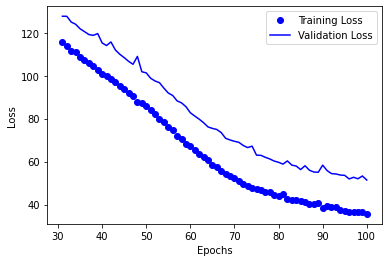

In [9]:
loss=history.history["loss"]
val_loss=history.history["val_loss"]
epochs=range(1, len(loss)+1)
plt.plot(epochs[30:], loss[30:], "bo", label="Training Loss")
plt.plot(epochs[30:], val_loss[30:], "b", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

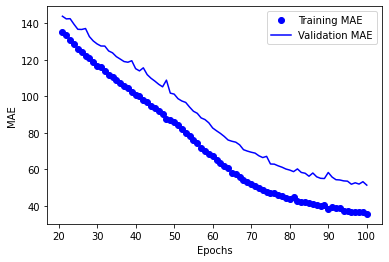

In [10]:
mae=history.history["mae"]
val_mae=history.history["val_mae"]
epochs=range(1, len(mae)+1)
plt.plot(epochs[20:], loss[20:], "bo", label="Training MAE")
plt.plot(epochs[20:], val_loss[20:], "b", label="Validation MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()
plt.show()

**Building The final Network**

In [11]:
model = models.Sequential()
model.add(layers.Dense(96, kernel_regularizer=regularizers.l1(l1=.001), activation = "relu", input_shape=(train_data.shape[1],)))
model.add(layers.Dense(10, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(8, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(6, kernel_regularizer=regularizers.l1(l1=.001),activation="relu"))
model.add(layers.Dense(1))
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

**Compiling the Final Netwrok**

In [12]:
model.fit(train_data, train_labels, epochs=100)

Epoch 1/100
23/23 [==============================] - 1s 1ms/step - loss: 1546.1007 - mae: 35.3880
Epoch 2/100
23/23 [==============================] - 0s 1ms/step - loss: 1354.3876 - mae: 32.7662
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 1181.2200 - mae: 30.2138
Epoch 4/100
23/23 [==============================] - 0s 1ms/step - loss: 931.4902 - mae: 26.3455
Epoch 5/100
23/23 [==============================] - 0s 1ms/step - loss: 610.8672 - mae: 20.1107
Epoch 6/100
23/23 [==============================] - 0s 2ms/step - loss: 393.9441 - mae: 15.6380
Epoch 7/100
23/23 [==============================] - 0s 1ms/step - loss: 230.7878 - mae: 12.0821
Epoch 8/100
23/23 [==============================] - 0s 2ms/step - loss: 176.6698 - mae: 10.6375
Epoch 9/100
23/23 [==============================] - 0s 1ms/step - loss: 187.2464 - mae: 10.9627
Epoch 10/100
23/23 [==============================] - 0s 1ms/step - loss: 184.5753 - mae: 10.9873
Epoch 11/100
23/23 [======

**Evaluating the Network**

In [13]:
test_mse_scoe, test_mae_score=model.evaluate(test_data, test_labels)

10/10 [==============================] - 0s 2ms/step - loss: 49.7531 - mae: 5.3222


In [14]:
test_mae_score

5.322227954864502

**Predicting the values**

In [15]:
denormalized = test_labels

In [16]:
prediction=model.predict(test_data)

In [17]:
pred_norm=prediction

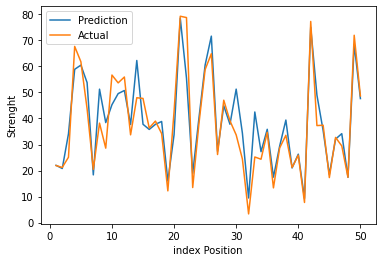

In [18]:
plt.plot(range(1, len(pred_norm[:300:6])+1), pred_norm[:300:6], label="Prediction")
plt.plot(range(1, len(pred_norm[:300:6])+1), denormalized[:300:6], label="Actual")
plt.xlabel("index Position")
plt.ylabel("Strenght")
plt.legend()
plt.show()
